In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import warnings

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
from typing import *
import numpy as np
import pandas as pd
from functools import partial
import math
from pathlib import Path
from collections import defaultdict
from prettytable import PrettyTable
from scipy.stats import ks_2samp
import h5py
import json

import torch
from torch import Tensor, nn
import torch.nn.functional as F

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

/Users/giles/anaconda3/envs/tomopt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Funcs

In [5]:
def make_comparison(geant_df:pd.DataFrame, pdg_scattering:Dict[str,Tensor], pgeant_scattering:Optional[Dict[str,Tensor]]=None, plots:bool=True, verbose:bool=True) -> Dict[str,Dict[str,float]]:
     # Make plots and tests
    tests = defaultdict(lambda: defaultdict(dict))

    def get_ks(a, b) -> float:
        try:
            p = ks_2samp(a, b).pvalue
        except:
            p = 0
        return p
    
    var = 'dangle_vol'
    if verbose:
        print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',pgeant_scattering)):
        if sim is None: continue
        tests[var][name]['mean_fdiff'] = np.abs(sim[var].mean()-geant_df[var].mean())/geant_df[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-geant_df[var].std())/geant_df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], geant_df[var])
        cut95 = np.percentile(geant_df[var],95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var] <= cut95], geant_df.loc[geant_df[var]<=cut95,var])
        cut68 = np.percentile(geant_df[var],68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var] <= cut68], geant_df.loc[geant_df[var]<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
    
    if plots:
        sns.distplot(geant_df[var], label='True GEANT')
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var], label=f'Param GEANT')
        sns.distplot(pdg_scattering[var], label='PDG')
        cut99 = np.percentile(geant_df[var],99.9)
        plt.xlim([0, cut99])
        plt.xlabel(var)
        plt.legend()
        plt.show()
    
        sns.distplot(geant_df.loc[geant_df[var].abs()>cut68, var].abs(), label='True GEANT')
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var][pgeant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
        sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
        plt.xlabel(f'|{var}|')
        plt.legend()
        plt.yscale('log')
        plt.ylim(1e-3, 1e4)
        plt.show()
    
    if verbose:
        print(tab)

    var = "dtheta_x_vol"
    if verbose:
        print("\n\n", var)
    tab: PrettyTable = None
    for name, sim in (("pdg", pdg_scattering), ("param_geant", pgeant_scattering)):
        if sim is None: continue
        tests[var][name]["mean"] = sim[var].mean()
        tests[var][name]["std_fdiff"] = np.abs(sim[var].std() - geant_df[var].std()) / geant_df[var].std()
        tests[var][name]["ks_p"] = get_ks(sim[var], geant_df[var])
        cut95 = np.percentile(geant_df[var].abs(), 95)
        tests[var][name]["bulk95_ks_p"] = get_ks(sim[var][sim[var].abs() <= cut95], geant_df.loc[geant_df[var].abs() <= cut95, var])
        cut68 = np.percentile(geant_df[var].abs(), 68)
        tests[var][name]["bulk68_ks_p"] = get_ks(sim[var][sim[var].abs() <= cut68], geant_df.loc[geant_df[var].abs() <= cut68, var])
        if tab is None:
            tab = PrettyTable(["Sim"] + [f for f in tests[var][name]])
        tab.add_row([name] + [v for k, v in tests[var][name].items()])

    if plots:
        sns.distplot(geant_df[var], label="True GEANT")
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var], label="Param GEANT")
        sns.distplot(pdg_scattering[var], label="PDG")
        cut99 = np.percentile(geant_df[var], 99.9)
        plt.xlim([-cut99, cut99])
        plt.xlabel(var)
        plt.legend()
        plt.show()

        sns.distplot(geant_df.loc[geant_df[var].abs() > cut68, var].abs(), label="True GEANT")
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var][pgeant_scattering[var].abs() > cut68].abs(), label="Param GEANT")
        sns.distplot(pdg_scattering[var][pdg_scattering[var].abs() > cut68].abs(), label="PDG")
        plt.xlabel(f"|{var}|")
        plt.legend()
        plt.yscale("log")
        plt.ylim(1e-3, 1e4)
        plt.show()

    if verbose:
        print(tab)

    var = "dtheta_y_vol"
    if verbose:
        print("\n\n", var)
    tab: PrettyTable = None
    for name, sim in (("pdg", pdg_scattering), ("param_geant", pgeant_scattering)):
        if sim is None: continue
        tests[var][name]["mean"] = sim[var].mean()
        tests[var][name]["std_fdiff"] = np.abs(sim[var].std() - geant_df[var].std()) / geant_df[var].std()
        tests[var][name]["ks_p"] = get_ks(sim[var], geant_df[var])
        cut95 = np.percentile(geant_df[var].abs(), 95)
        tests[var][name]["bulk95_ks_p"] = get_ks(sim[var][sim[var].abs() <= cut95], geant_df.loc[geant_df[var].abs() <= cut95, var])
        cut68 = np.percentile(geant_df[var].abs(), 68)
        tests[var][name]["bulk68_ks_p"] = get_ks(sim[var][sim[var].abs() <= cut68], geant_df.loc[geant_df[var].abs() <= cut68, var])
        if tab is None:
            tab = PrettyTable(["Sim"] + [f for f in tests[var][name]])
        tab.add_row([name] + [v for k, v in tests[var][name].items()])

    if plots:
        sns.distplot(geant_df[var], label="True GEANT")
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var], label="Param GEANT")
        sns.distplot(pdg_scattering[var], label="PDG")
        cut99 = np.percentile(geant_df[var], 99.9)
        plt.xlim([-cut99, cut99])
        plt.xlabel(var)
        plt.legend()
        plt.show()

        sns.distplot(geant_df.loc[geant_df[var].abs() > cut68, var].abs(), label="True GEANT")
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var][pgeant_scattering[var].abs() > cut68].abs(), label="Param GEANT")
        sns.distplot(pdg_scattering[var][pdg_scattering[var].abs() > cut68].abs(), label="PDG")
        plt.xlabel(f"|{var}|")
        plt.legend()
        plt.yscale("log")
        plt.ylim(1e-3, 1e4)
        plt.show()

    if verbose:
        print(tab)
        
    var = 'dspace_vol'
    if verbose:
        print('\n\n',var)
    tab:PrettyTable = None
    for name,sim in (('pdg',pdg_scattering),('param_geant',pgeant_scattering)):
        if sim is None: continue
        tests[var][name]['mean_fdiff'] = np.abs(sim[var].mean()-geant_df[var].mean())/geant_df[var].mean()
        tests[var][name]['std_fdiff'] = np.abs(sim[var].std()-geant_df[var].std())/geant_df[var].std()
        tests[var][name]['ks_p'] = get_ks(sim[var], geant_df[var])
        cut95 = np.percentile(geant_df[var],95)
        tests[var][name]['bulk95_ks_p'] = get_ks(sim[var][sim[var] <= cut95], geant_df.loc[geant_df[var]<=cut95,var])
        cut68 = np.percentile(geant_df[var],68)
        tests[var][name]['bulk68_ks_p'] = get_ks(sim[var][sim[var] <= cut68], geant_df.loc[geant_df[var]<=cut68,var])
        if tab is None: tab = PrettyTable(['Sim']+[f for f in tests[var][name]])
        tab.add_row([name]+[v for k,v in tests[var][name].items()])
        
    if plots:
        sns.distplot(geant_df[var], label='True GEANT')
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var], label=f'Param GEANT')
        sns.distplot(pdg_scattering[var], label='PDG')
        cut99 = np.percentile(geant_df[var],99.9)
        plt.xlim([0, cut99])
        plt.xlabel(var)
        plt.legend()
        plt.show()

        sns.distplot(geant_df.loc[geant_df[var].abs()>cut68, var].abs(), label='True GEANT')
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var][pgeant_scattering[var].abs()>cut68].abs(), label='Param GEANT')
        sns.distplot(pdg_scattering[var][pdg_scattering[var].abs()>cut68].abs(), label='PDG')
        plt.xlabel(f'|{var}|')
        plt.legend()
        plt.yscale('log')
        plt.ylim(1e-1, 1e6)
        plt.show()
    
    if verbose:
        print(tab)

    var = "dx_vol"
    if verbose:
        print("\n\n", var)
    tab: PrettyTable = None
    for name, sim in (("pdg", pdg_scattering), ("param_geant", pgeant_scattering)):
        if sim is None: continue
        tests[var][name]["mean"] = sim[var].mean()
        tests[var][name]["std_fdiff"] = np.abs(sim[var].std() - geant_df[var].std()) / geant_df[var].std()
        tests[var][name]["ks_p"] = get_ks(sim[var], geant_df[var])
        cut95 = np.percentile(geant_df[var].abs(), 95)
        tests[var][name]["bulk95_ks_p"] = get_ks(sim[var][sim[var].abs() <= cut95], geant_df.loc[geant_df[var].abs() <= cut95, var])
        cut68 = np.percentile(geant_df[var].abs(), 68)
        tests[var][name]["bulk68_ks_p"] = get_ks(sim[var][sim[var].abs() <= cut68], geant_df.loc[geant_df[var].abs() <= cut68, var])
        if tab is None:
            tab = PrettyTable(["Sim"] + [f for f in tests[var][name]])
        tab.add_row([name] + [v for k, v in tests[var][name].items()])

    if plots:
        sns.distplot(geant_df[var], label="True GEANT")
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var], label="Param GEANT")
        sns.distplot(pdg_scattering[var], label="PDG")
        cut99 = np.percentile(geant_df[var], 99.9)
        plt.xlim([-cut99, cut99])
        plt.xlabel(var)
        plt.legend()
        plt.show()

        sns.distplot(geant_df.loc[geant_df[var].abs() > cut68, var].abs(), label="True GEANT")
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var][pgeant_scattering[var].abs() > cut68].abs(), label="Param GEANT")
        sns.distplot(pdg_scattering[var][pdg_scattering[var].abs() > cut68].abs(), label="PDG")
        plt.xlabel(f"|{var}|")
        plt.legend()
        plt.yscale("log")
        plt.ylim(1e-1, 1e6)
        plt.show()

    if verbose:
        print(tab)

    var = "dy_vol"
    if verbose:
        print("\n\n", var)
    tab: PrettyTable = None
    for name, sim in (("pdg", pdg_scattering), ("param_geant", pgeant_scattering)):
        if sim is None: continue
        tests[var][name]["mean"] = sim[var].mean()
        tests[var][name]["std_fdiff"] = np.abs(sim[var].std() - geant_df[var].std()) / geant_df[var].std()
        tests[var][name]["ks_p"] = get_ks(sim[var], geant_df[var])
        cut95 = np.percentile(geant_df[var].abs(), 95)
        tests[var][name]["bulk95_ks_p"] = get_ks(sim[var][sim[var].abs() <= cut95], geant_df.loc[geant_df[var].abs() <= cut95, var])
        cut68 = np.percentile(geant_df[var].abs(), 68)
        tests[var][name]["bulk68_ks_p"] = get_ks(sim[var][sim[var].abs() <= cut68], geant_df.loc[geant_df[var].abs() <= cut68, var])
        if tab is None:
            tab = PrettyTable(["Sim"] + [f for f in tests[var][name]])
        tab.add_row([name] + [v for k, v in tests[var][name].items()])

    if plots:
        sns.distplot(geant_df[var], label="True GEANT")
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var], label="Param GEANT")
        sns.distplot(pdg_scattering[var], label="PDG")
        cut99 = np.percentile(geant_df[var], 99.9)
        plt.xlim([-cut99, cut99])
        plt.xlabel(var)
        plt.legend()
        plt.show()

        sns.distplot(geant_df.loc[geant_df[var].abs() > cut68, var].abs(), label="True GEANT")
        if pgeant_scattering is not None: sns.distplot(pgeant_scattering[var][pgeant_scattering[var].abs() > cut68].abs(), label="Param GEANT")
        sns.distplot(pdg_scattering[var][pdg_scattering[var].abs() > cut68].abs(), label="PDG")
        plt.xlabel(f"|{var}|")
        plt.legend()
        plt.yscale("log")
        plt.ylim(1e-1, 1e6)
        plt.show()

    if verbose:
        print(tab)
    
    return tests

In [6]:
warnings.filterwarnings('ignore')
def get_scatters(grp:h5py.Group, n_steps:int, plots:bool, verbose:bool) -> Dict[str,Any]:
    
    
    # Get data & settings
    settings = json.loads(grp['settings'][()])
    df = pd.DataFrame(grp['data'][()], columns=settings['columns'])

    # Get settings
    mat = settings['mat']
    dz = float(settings['dz'])
    mom = float(settings['mom'])
    theta = float(settings['theta'])
    phi = float(settings['phi'])
    n_muons = int(settings['n_muons'])
    
    # Init layer
    step_sz=dz/(n_steps*np.cos(theta))
    layer = PassiveLayer(lw=Tensor([dz*100,dz*100]), z=1, size=dz, step_sz=step_sz)
    layer.rad_length = torch.ones(list((layer.lw / layer.size).long())) * X0[mat]
    
    if verbose: print(f'Making scatterings for {mat=}, {dz=}, ~{n_steps=} @ {step_sz=}m, {mom=}, {theta=}, {phi=}, {n_muons=}')
    
    # Get pdg_scatterings
    xy_m_t_p = torch.ones(n_muons, 5)
    xy_m_t_p[:,:2] =dz*50
    xy_m_t_p[:,2] = mom
    xy_m_t_p[:,3] = theta
    xy_m_t_p[:,4] = phi
    muons = MuonBatch(xy_m_t_p, init_z=1)
    start = muons.copy()
    layer(muons)
    start.propagate_dz(dz)  # Propagate without scattering
    pdg_scattering = {}
    pdg_scattering['dtheta_x_vol'] = muons.theta_x-start.theta_x
    pdg_scattering['dtheta_y_vol'] = muons.theta_y-start.theta_y
    pdg_scattering['dx_vol'] = muons.x-start.x
    pdg_scattering['dy_vol'] = muons.y-start.y
    pdg_scattering['dangle_vol'] = np.sqrt((pdg_scattering['dtheta_x_vol']**2)+(pdg_scattering['dtheta_y_vol']**2))
    pdg_scattering['dspace_vol'] = np.sqrt((pdg_scattering['dx_vol']**2)+(pdg_scattering['dy_vol']**2))
    # Make plots and tests
    tests = make_comparison(df, pdg_scattering, pgeant_scattering=None, plots=plots, verbose=verbose)
    
    return {'data':{'df':df, 'pdg':pdg_scattering}, 'tests':tests}

In [7]:
def check_scatter_tests(tests:Dict[str,Dict[str,Dict[str,float]]], pdg_pmin:Optional[float], geant_pmin:Optional[float], test:str='bulk68_ks_p', ignore_vars:Optional[List[str]]=None) -> bool:
    if ignore_vars is None: ignore_vars = []
    else: print(f'Ignoring {ignore_vars}')
    for var in [v for v in tests if v not in ignore_vars]:
        if pdg_pmin is not None:
            if tests[var]['pdg'][test] < pdg_pmin:
                print(f'{var}, failed for PDG {test} = {tests[var]["pdg"][test]}')
                return False
        if geant_pmin is not None:
            if tests[var]['pdg'][test] < geant_pmin:
                print(f'{var}, failed for parameterised GEANT {test} = {etsts[var]["param_geant"][test]}')
                return False
    return True

In [8]:
data = h5py.File('../tests/data/geant_scatter_validation.hdf5', 'r')

In [9]:
data.keys()

<KeysViewHDF5 ['Al_1cm_5GeV_normal', 'Cu_1cm_5GeV_normal', 'Fe_10cm_5GeV_normal', 'Fe_1cm_1GeV_normal', 'Fe_1cm_50GeV_normal', 'Fe_1cm_5GeV_ZenithAngle=pi4', 'Fe_1cm_5GeV_normal', 'U_1cm_5GeV_normal']>

results = get_scatters(data['Al_1cm_5GeV_normal'], n_steps=1, plots=True, verbose=True)

results = get_scatters(data['Al_1cm_5GeV_normal'], n_steps=10, plots=True, verbose=True)

In [10]:
for check in data.keys():
    print('\n\n',check)
    for i in range(5):
        results = get_scatters(data[check], plots=False, verbose=False, n_steps=1)
        if check_scatter_tests(results['tests'], pdg_pmin=0.01, geant_pmin=None, ignore_vars=['dangle_vol', 'dspace_vol']): print(f'Passed after {i+1} tries'); break
        if i == 4: print(f'Failed after 5 tries')



 Al_1cm_5GeV_normal
Ignoring ['dangle_vol', 'dspace_vol']
dx_vol, failed for PDG bulk68_ks_p = 0.0062394789222601854
Ignoring ['dangle_vol', 'dspace_vol']
dx_vol, failed for PDG bulk68_ks_p = 0.0020734619296795386
Ignoring ['dangle_vol', 'dspace_vol']
dy_vol, failed for PDG bulk68_ks_p = 6.225002169258533e-06
Ignoring ['dangle_vol', 'dspace_vol']
dtheta_y_vol, failed for PDG bulk68_ks_p = 0.007850946547826686
Ignoring ['dangle_vol', 'dspace_vol']
dy_vol, failed for PDG bulk68_ks_p = 0.00012194342191428771
Failed after 5 tries


 Cu_1cm_5GeV_normal
Ignoring ['dangle_vol', 'dspace_vol']
Passed after 1 tries


 Fe_10cm_5GeV_normal
Ignoring ['dangle_vol', 'dspace_vol']
dx_vol, failed for PDG bulk68_ks_p = 0.00011544533593280164
Ignoring ['dangle_vol', 'dspace_vol']
dx_vol, failed for PDG bulk68_ks_p = 0.00018941477656322808
Ignoring ['dangle_vol', 'dspace_vol']
dx_vol, failed for PDG bulk68_ks_p = 8.367274308858513e-05
Ignoring ['dangle_vol', 'dspace_vol']
dx_vol, failed for PDG bulk68_k

Making scatterings for mat='iron', dz=0.01, ~n_steps=5 @ step_sz=0.00282842712474619m, mom=5.0, theta=0.7853981633974483, phi=0.0, n_muons=100000


 dangle_vol


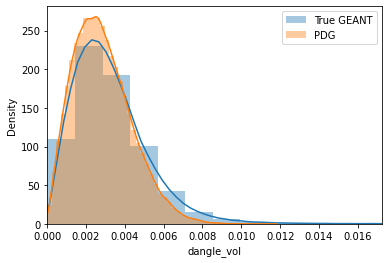

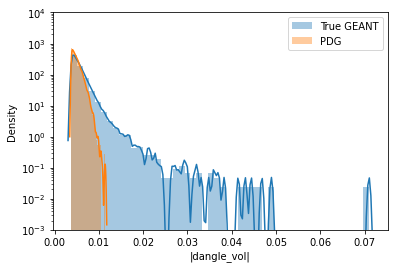

+-----+----------------+----------------+------------------------+------------------------+------------------------+
| Sim |   mean_fdiff   |   std_fdiff    |          ks_p          |      bulk95_ks_p       |      bulk68_ks_p       |
+-----+----------------+----------------+------------------------+------------------------+------------------------+
| pdg | tensor(0.1269) | tensor(0.2764) | 1.768008161543045e-252 | 6.568120660250375e-109 | 1.1864237526525994e-07 |
+-----+----------------+----------------+------------------------+------------------------+------------------------+


 dtheta_x_vol


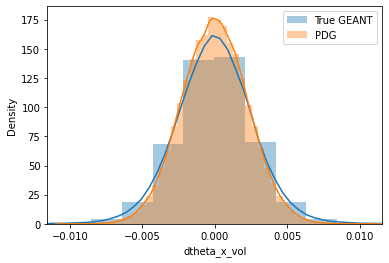

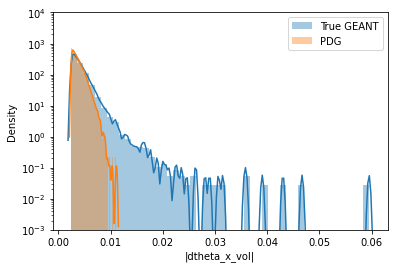

+-----+---------------------+----------------+-----------------------+-----------------------+---------------------+
| Sim |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p      |     bulk68_ks_p     |
+-----+---------------------+----------------+-----------------------+-----------------------+---------------------+
| pdg | tensor(-3.9334e-06) | tensor(0.1688) | 2.853530118428909e-35 | 5.123048135962409e-12 | 0.09080683116819122 |
+-----+---------------------+----------------+-----------------------+-----------------------+---------------------+


 dtheta_y_vol


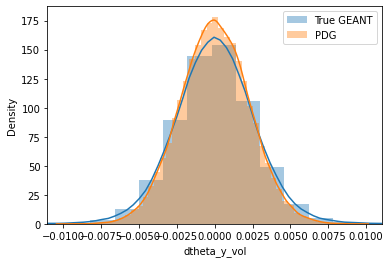

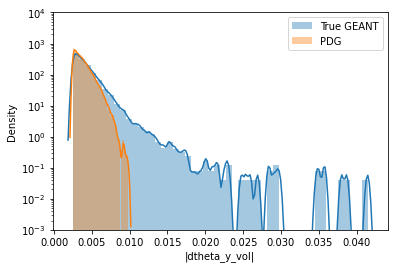

+-----+---------------------+----------------+-----------------------+-----------------------+---------------------+
| Sim |         mean        |   std_fdiff    |          ks_p         |      bulk95_ks_p      |     bulk68_ks_p     |
+-----+---------------------+----------------+-----------------------+-----------------------+---------------------+
| pdg | tensor(-2.0910e-06) | tensor(0.1647) | 5.271480710933281e-32 | 6.261682266563313e-12 | 0.34256882141708045 |
+-----+---------------------+----------------+-----------------------+-----------------------+---------------------+


 dspace_vol


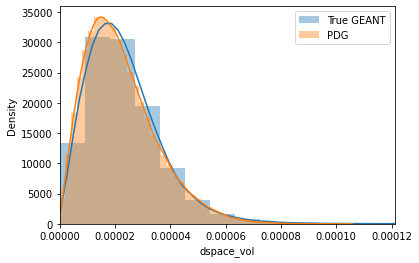

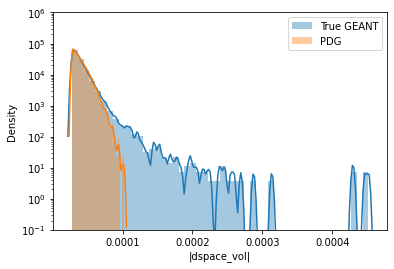

+-----+----------------+----------------+------------------------+----------------------+------------------------+
| Sim |   mean_fdiff   |   std_fdiff    |          ks_p          |     bulk95_ks_p      |      bulk68_ks_p       |
+-----+----------------+----------------+------------------------+----------------------+------------------------+
| pdg | tensor(0.0529) | tensor(0.1114) | 1.6613318594977953e-70 | 3.82200474868066e-65 | 1.0403972063076308e-49 |
+-----+----------------+----------------+------------------------+----------------------+------------------------+


 dx_vol


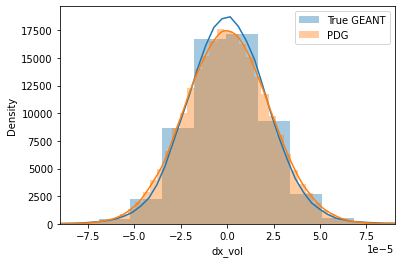

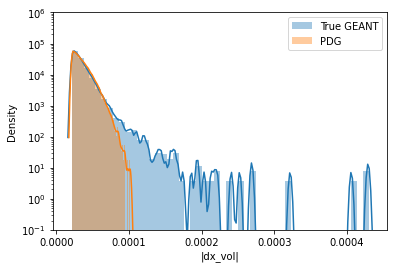

+-----+--------------------+----------------+----------------------+-----------------------+----------------------+
| Sim |        mean        |   std_fdiff    |         ks_p         |      bulk95_ks_p      |     bulk68_ks_p      |
+-----+--------------------+----------------+----------------------+-----------------------+----------------------+
| pdg | tensor(6.5493e-08) | tensor(0.0132) | 8.48018371064244e-16 | 3.170947607602713e-12 | 0.028649304094268135 |
+-----+--------------------+----------------+----------------------+-----------------------+----------------------+


 dy_vol


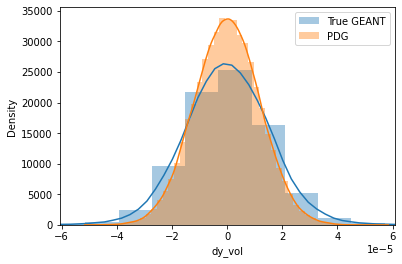

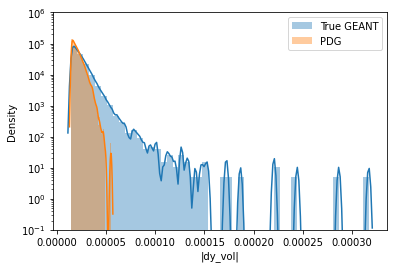

+-----+--------------------+----------------+-------------------------+-----------------------+-----------------------+
| Sim |        mean        |   std_fdiff    |           ks_p          |      bulk95_ks_p      |      bulk68_ks_p      |
+-----+--------------------+----------------+-------------------------+-----------------------+-----------------------+
| pdg | tensor(2.1547e-10) | tensor(0.2609) | 2.5887017979494744e-169 | 7.15371935079836e-106 | 3.219534122856599e-13 |
+-----+--------------------+----------------+-------------------------+-----------------------+-----------------------+


In [11]:
results = get_scatters(data['Fe_1cm_5GeV_ZenithAngle=pi4'], n_steps=5, plots=True, verbose=True)

In [12]:
dtheta_xy = torch.randn(2,1000)

In [13]:
xy_m_t_p = torch.ones(1000, 5)
xy_m_t_p[:,:2] = 0.01*50
xy_m_t_p[:,2] = 5
xy_m_t_p[:,3] = torch.pi/4
xy_m_t_p[:,4] = 0
muons = MuonBatch(xy_m_t_p, init_z=1)

In [14]:
muons1 = muons.copy()
muons1.scatter_dtheta_dphi(dtheta_vol=dtheta_xy[0], dphi_vol=dtheta_xy[1])

In [15]:
muons1.theta_xy

tensor([[ 0.3100, -0.1180],
        [ 0.5977,  0.0878],
        [ 0.0105,  0.0102],
        ...,
        [ 1.4106, -1.4387],
        [ 1.5017, -1.2835],
        [-0.4971,  0.1363]])

In [16]:
muons2 = muons.copy()
muons2.scatter_dtheta_xy(dtheta_x_vol=dtheta_xy[0], dtheta_y_vol=dtheta_xy[1])

In [17]:
muons2.theta_xy

tensor([[ 0.3291, -0.3544],
        [ 0.6016,  0.1285],
        [ 0.0146,  0.7702],
        ...,
        [ 1.4685, -0.8825],
        [ 1.5035, -0.2301],
        [-0.5102, -0.2477]])

In [18]:
muons.theta_xy

tensor([[0.7854, 0.0000],
        [0.7854, 0.0000],
        [0.7854, 0.0000],
        ...,
        [0.7854, 0.0000],
        [0.7854, 0.0000],
        [0.7854, 0.0000]])

In [19]:
dtheta_xy

tensor([[-0.4562, -0.1838, -0.7708,  ...,  0.6831,  0.7181, -1.2956],
        [-0.3544,  0.1285,  0.7702,  ..., -0.8825, -0.2301, -0.2477]])

In [20]:
muons.theta_xy+dtheta_xy.T

tensor([[ 0.3291, -0.3544],
        [ 0.6016,  0.1285],
        [ 0.0146,  0.7702],
        ...,
        [ 1.4685, -0.8825],
        [ 1.5035, -0.2301],
        [-0.5102, -0.2477]])

In [21]:
theta_x = muons.theta_x_from_theta_phi(muons.theta, muons.phi)
theta_y = muons.theta_y_from_theta_phi(muons.theta, muons.phi)

In [22]:
theta_x += dtheta_xy[0]
theta_y += dtheta_xy[1]

In [23]:
muons.theta_from_theta_xy(theta_x, theta_y)

tensor([0.4665, 0.6097, 0.7703,    nan, 0.9681,    nan,    nan, 0.9084, 0.7733,
           nan, 1.1770,    nan,    nan,    nan, 1.0418, 1.3897, 1.1784,    nan,
        0.7968, 0.6827,    nan,    nan,    nan, 1.5605, 0.8890,    nan,    nan,
        1.0248, 0.6234, 0.8782, 0.5612,    nan,    nan, 1.1714, 1.0508,    nan,
           nan, 1.1271, 1.1333,    nan, 1.1302, 0.8925,    nan,    nan, 1.1665,
        0.8046, 1.1497, 1.0110, 1.1883,    nan, 0.8584, 0.7444, 0.9770,    nan,
        0.9521, 0.9361, 1.0502,    nan,    nan, 0.5360, 1.3945, 1.1794,    nan,
           nan, 1.3685, 1.1068,    nan,    nan,    nan, 0.5674, 0.7873, 1.5082,
        0.8375,    nan,    nan, 0.3280,    nan,    nan, 1.4104, 1.4526,    nan,
           nan,    nan,    nan, 1.3939,    nan, 1.1254, 1.0858, 1.4558, 0.2207,
           nan,    nan, 1.0297, 0.8362,    nan, 0.7524, 0.6125, 0.9234, 0.4192,
        0.5085, 0.8396, 1.2981, 1.1748, 1.1066,    nan, 0.9896, 0.6389, 1.0937,
           nan,    nan, 1.1943,    nan, 

In [24]:
phi = muons.phi_from_theta_xy(theta_x, theta_y)

In [25]:
phi

tensor([5.4578e+00, 1.8607e-01, 1.5558e+00,        nan, 4.1739e+00,        nan,
               nan, 1.1523e+00, 8.1398e-01,        nan, 9.2279e-02,        nan,
               nan,        nan, 6.2799e+00, 5.3897e-01, 1.4784e+00,        nan,
        9.4990e-01, 7.0761e-01,        nan,        nan,        nan, 1.5638e+00,
        6.0321e+00,        nan,        nan, 2.8036e+00, 5.9649e-01, 1.7088e-01,
        4.1057e+00,        nan,        nan, 1.6145e+00, 5.7077e+00,        nan,
               nan, 6.1631e+00, 9.2561e-01,        nan, 4.8194e+00, 7.3309e-01,
               nan,        nan, 6.5259e-01, 7.7177e-01, 6.2638e+00, 5.8834e+00,
        3.1446e+00,        nan, 1.5603e-01, 4.4457e+00, 1.5322e+00,        nan,
        1.8389e-02, 6.1905e+00, 1.1421e+00,        nan,        nan, 1.4060e-01,
        4.6407e+00, 1.7960e-01,        nan,        nan, 6.0078e+00, 5.1240e+00,
               nan,        nan,        nan, 3.9509e+00, 4.6446e+00, 4.6884e+00,
        4.2193e+00,        nan,        n

In [26]:
torch.arctan(theta_y.tan() / theta_x.tan())

tensor([-8.2540e-01,  1.8607e-01,  1.5558e+00,  1.2522e-02,  1.0323e+00,
        -1.5672e+00, -1.0351e+00,  1.1523e+00,  8.1398e-01,  3.7923e-01,
         9.2279e-02,  1.5020e-01,  4.5946e-02, -1.6931e-01, -3.2517e-03,
         5.3897e-01,  1.4784e+00,  5.9075e-01,  9.4990e-01,  7.0761e-01,
         1.3939e+00, -6.0991e-01, -3.3871e-01,  1.5638e+00, -2.5109e-01,
         1.0447e+00, -1.4278e+00, -3.3802e-01,  5.9649e-01,  1.7088e-01,
         9.6415e-01, -1.4467e+00, -1.4964e+00, -1.5271e+00, -5.7547e-01,
         4.3097e-01,  1.4343e+00, -1.2005e-01,  9.2561e-01, -8.1719e-01,
        -1.4638e+00,  7.3309e-01, -7.2678e-01, -6.1092e-01,  6.5259e-01,
         7.7177e-01, -1.9421e-02, -3.9977e-01,  3.0295e-03,  7.7140e-01,
         1.5603e-01,  1.3041e+00,  1.5322e+00, -2.1996e-01,  1.8389e-02,
        -9.2648e-02,  1.1421e+00, -1.6095e-01, -1.3799e+00,  1.4060e-01,
         1.4991e+00,  1.7960e-01, -8.9990e-03, -8.0132e-01, -2.7541e-01,
        -1.1592e+00, -1.0648e+00, -2.2428e-01, -4.4

In [27]:
muons2.theta

tensor([0.4665, 0.6097, 0.7703, 0.9681, 0.9084, 0.7733, 1.1770, 1.0418, 1.3897,
        1.1784, 0.7968, 0.6827, 1.5605, 0.8890, 1.0248, 0.6234, 0.8782, 0.5612,
        1.1714, 1.0508, 1.1271, 1.1333, 1.1302, 0.8925, 1.1665, 0.8046, 1.1497,
        1.0110, 1.1883, 0.8584, 0.7444, 0.9770, 0.9521, 0.9361, 1.0502, 0.5360,
        1.3945, 1.1794, 1.3685, 1.1068, 0.5674, 0.7873, 1.5082, 0.8375, 0.3280,
        1.4104, 1.4526, 1.3939, 1.1254, 1.0858, 1.4558, 0.2207, 1.0297, 0.8362,
        0.7524, 0.6125, 0.9234, 0.4192, 0.5085, 0.8396, 1.2981, 1.1748, 1.1066,
        0.9896, 0.6389, 1.0937, 1.1943, 1.4563, 0.5297, 0.5873, 0.4715, 1.0013,
        0.9805, 1.4885, 1.0622, 1.2221, 1.4007, 1.1450, 1.2538, 0.8040, 0.2773,
        0.7859, 0.5366, 1.4023, 1.3742, 1.4964, 0.4040, 0.4566, 0.3817, 0.8708,
        1.4895, 1.5423, 1.0315, 0.2952, 1.4454, 1.0647, 1.1130, 0.9184, 1.4916,
        0.9449, 1.1921, 1.4380, 1.5477, 1.1083, 1.1452, 0.2905, 1.1114, 0.4335,
        0.9863, 0.8979, 1.4207, 0.8716, 

In [28]:
muons2.phi

tensor([5.4578e+00, 1.8607e-01, 1.5558e+00, 4.1739e+00, 1.1523e+00, 8.1398e-01,
        9.2279e-02, 6.2799e+00, 5.3897e-01, 1.4784e+00, 9.4990e-01, 7.0761e-01,
        1.5638e+00, 6.0321e+00, 2.8036e+00, 5.9649e-01, 1.7088e-01, 4.1057e+00,
        1.6145e+00, 5.7077e+00, 6.1631e+00, 9.2561e-01, 4.8194e+00, 7.3309e-01,
        6.5259e-01, 7.7177e-01, 6.2638e+00, 5.8834e+00, 3.1446e+00, 1.5603e-01,
        4.4457e+00, 1.5322e+00, 1.8389e-02, 6.1905e+00, 1.1421e+00, 1.4060e-01,
        4.6407e+00, 1.7960e-01, 6.0078e+00, 5.1240e+00, 3.9509e+00, 4.6446e+00,
        4.6884e+00, 4.2193e+00, 1.9906e+00, 4.7036e+00, 6.1832e+00, 1.3516e+00,
        1.5327e+00, 5.9525e-01, 1.5923e+00, 4.4879e+00, 1.5606e-01, 9.5943e-01,
        1.1754e+00, 6.1656e+00, 4.5830e+00, 1.8328e+00, 1.2009e+00, 6.2197e+00,
        3.1187e+00, 1.1129e-01, 5.7532e+00, 2.3513e+00, 2.7287e+00, 7.2919e-01,
        3.0549e-02, 4.6545e+00, 5.1421e+00, 5.4963e+00, 6.2674e-01, 7.7961e-02,
        1.8873e-01, 1.5042e+00, 3.7576e+